
--- Cross-Validation Results (on Training Set) ---
CV R² score for N2O: 0.763
CV RMSE for N2O: 0.035
CV R² score for CH4: 0.984
CV RMSE for CH4: 0.009


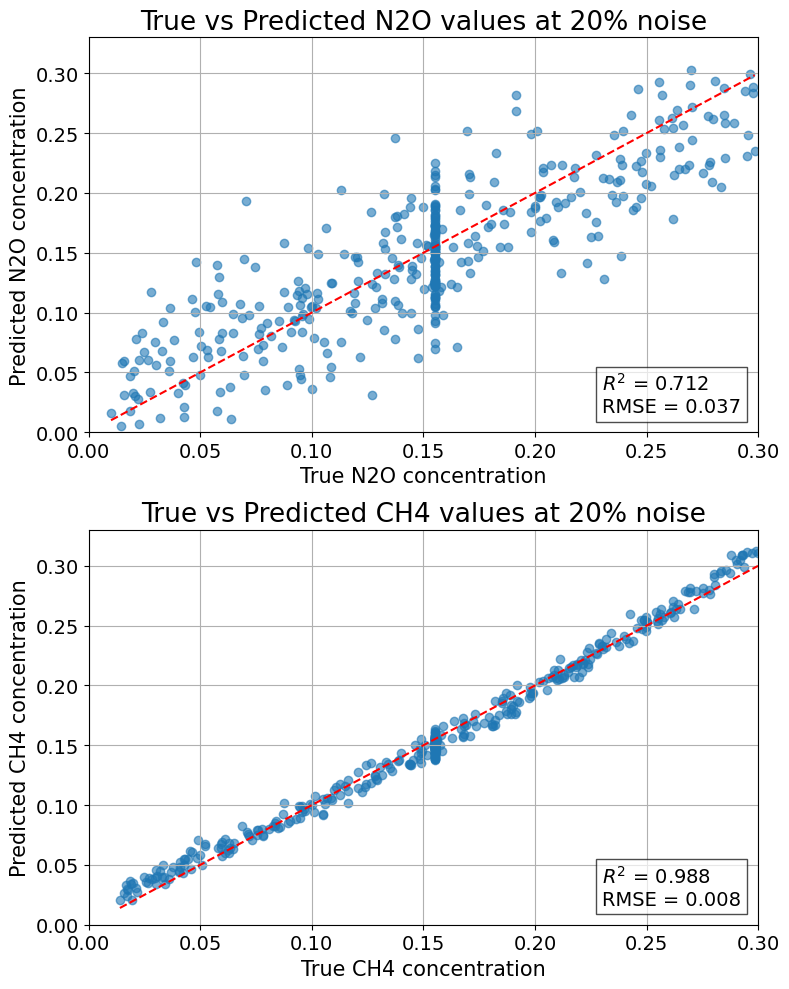

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error

gases = ["N2O", "CH4"]

# Load spectra and labels
spectra_df = pd.read_csv(f"{gasA}_{gasB}_spectra_double_noisy.csv")
labels_df = pd.read_csv(f"{gasA}_{gasB}_label_double.csv")
X = spectra_df
y = labels_df[[gasA, gasB]]

# Standardize spectra
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, shuffle=True)

# Cross-validation on training set
cv = KFold(n_splits=10, shuffle=True)
n_components = 10
pls_cv = PLSRegression(n_components=n_components)
y_train_cv_pred = cross_val_predict(pls_cv, X_train, y_train, cv=cv)

print("\n Cross-Validation Results (on Training Set)")
for i, gas in enumerate(gases):
    r2_cv = r2_score(y_train[gas], y_train_cv_pred[:, i])
    rmse_cv = mean_squared_error(y_train[gas], y_train_cv_pred[:, i], squared=False)
    print(f"CV R$^2$ score for {gas}: {r2_cv:.3f}")
    print(f"CV RMSE for {gas}: {rmse_cv:.3f}")

# Evaluate on test set
pls_final = PLSRegression(n_components=n_components)
pls_final.fit(X_train, y_train)
y_test_pred = pls_final.predict(X_test)

# Plots
plt.figure(figsize=(8, 10))

for i, gas in enumerate(gases):
    
    r2_test = r2_score(y_test[gas], y_test_pred[:, i])
    rmse_test = mean_squared_error(y_test[gas], y_test_pred[:, i], squared=False)
    
    plt.subplot(len(gases), 1, i + 1)
    plt.scatter(y_test[gas], y_test_pred[:, i], alpha=0.6)
    plt.xlabel(f"True {gas} concentration", fontsize=15)
    plt.ylabel(f"Predicted {gas} concentration", fontsize=15)
    plt.title(f"True vs Predicted {gas} values at 20% noise", fontsize=19)
    
    plt.plot([y_test[gas].min(), y_test[gas].max()], [y_test[gas].min(), y_test[gas].max()], 'r--')

    plt.text(
        0.23, 0.05,  
        f"R$^2$ = {r2_test:.3f}\nRMSE = {rmse_test:.3f}",
        fontsize=14,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.7)
    )
    
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0,0.3)
    plt.ylim(0, 0.33)

plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error

gasA = "N2O"
gasB = "CH4"

# Load spectra and labels
spectra_df = pd.read_csv(f"{gasA}_{gasB}_spectra_double_noisy.csv")
labels_df = pd.read_csv(f"{gasA}_{gasB}_label_double.csv")
X = spectra_df.values
y = labels_df[[gasA, gasB]].values

# Standardize spectra
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cross-validation for optimal components
kf = KFold(n_splits=10, shuffle=True,)
max_components = min(30, X_scaled.shape[1])

mean_r2_scores = []
mean_rmse_scores = []

for n_comp in range(1, max_components + 1):
    pls = PLSRegression(n_components=n_comp)
    r2_scores = []
    rmse_scores = []
    
    for train_idx, test_idx in kf.split(X_scaled):
        X_train_cv, X_test_cv = X_scaled[train_idx], X_scaled[test_idx]
        y_train_cv, y_test_cv = y[train_idx], y[test_idx]
        
        pls.fit(X_train_cv, y_train_cv)
        y_pred_cv = pls.predict(X_test_cv)
        
        r2 = [r2_score(y_test_cv[:, i], y_pred_cv[:, i]) for i in range(y.shape[1])]
        rmse = [mean_squared_error(y_test_cv[:, i], y_pred_cv[:, i], squared=False) for i in range(y.shape[1])]
        
        r2_scores.append(np.mean(r2))
        rmse_scores.append(np.mean(rmse))
    
    mean_r2_scores.append(np.mean(r2_scores))
    mean_rmse_scores.append(np.mean(rmse_scores))

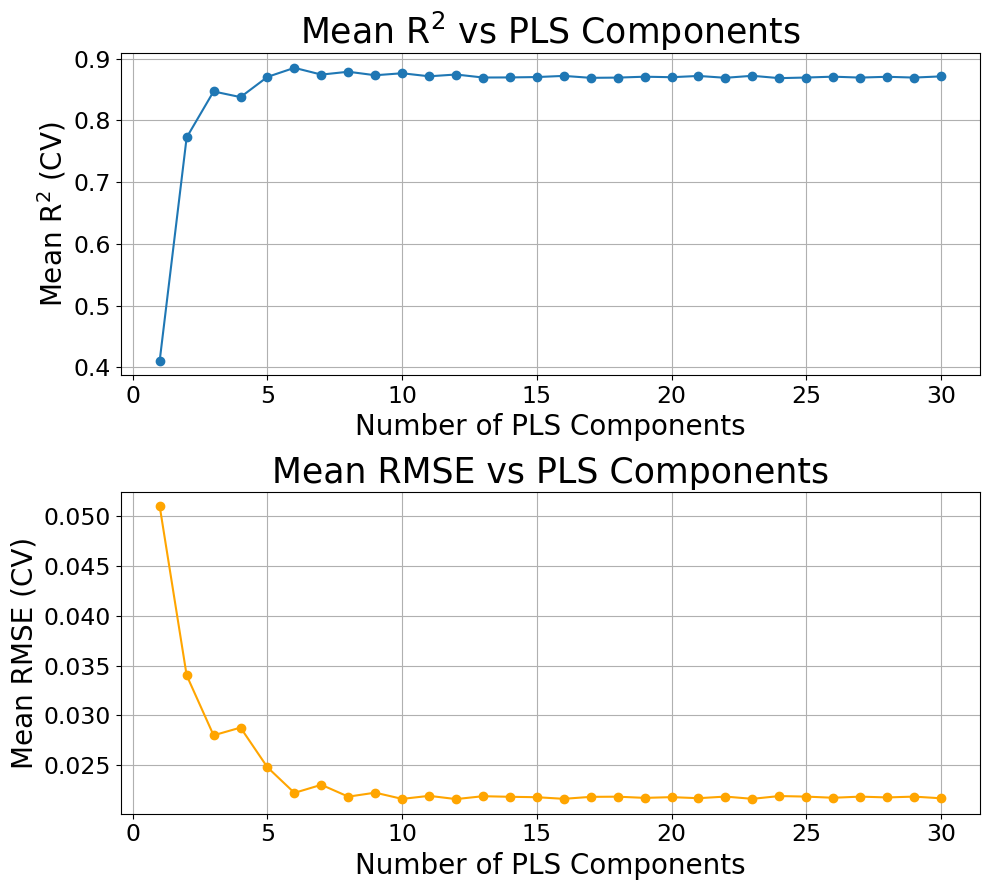

Optimal number of PLS components: 6


In [3]:
plt.figure(figsize=(10, 9))

# Mean R2
plt.subplot(2, 1, 1)
plt.plot(range(1, max_components + 1), mean_r2_scores, marker='o')
plt.xlabel("Number of PLS Components", fontsize=20)
plt.ylabel("Mean R$^2$ (CV)", fontsize=20)
plt.title("Mean R$^2$ vs PLS Components", fontsize=25)
plt.grid(True)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

# Mean RMSE
plt.subplot(2, 1, 2)
plt.plot(range(1, max_components + 1), mean_rmse_scores, marker='o', color='orange')
plt.xlabel("Number of PLS Components", fontsize=20)
plt.ylabel("Mean RMSE (CV)", fontsize=20)
plt.title("Mean RMSE vs PLS Components", fontsize=25)
plt.grid(True)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

plt.tight_layout()
plt.show()